This is a companions notebook of the paper: [**The Likelihood Gain of a Language Model as a
Metric for Text Summarization**
](https://)



In this notebook we explore LLG (log likelihood gain), an information theoretical metric for text summary evaluation. The structure of the notebook is as follows:

1.   Overview of text summarization task
2.   Summary evaluation task: importance, challenges and familiar metrics
3.   Shannon game
4.   LLG code and evaluation datasets
5.   Information theoretical justifications:
 *   Loseless compression - Arithmetic coding
 *   Normalized compression distance (NCD)
 *   Linguistic analysis: content VS function words


# Overview of text Summarization task

Automatic text summarization, a core task in Natural Language Processing (NLP), condenses lengthy or multiple texts into concise summaries while retaining key information. Its applications span diverse domains, including summarization for academia and business, news summarization, email management, meeting notes, legal documents, e-commerce reviews, social media, healthcare, and more.

Two main summarization types are extractive, which selects existing content directly from the source text, and abstractive, which generates concise summaries by interpreting and potentially paraphrasing information. To demonstrate, in the examples below we generate an abstractive summary using Pegasus model and an extractive summary using LexRank algorithm.

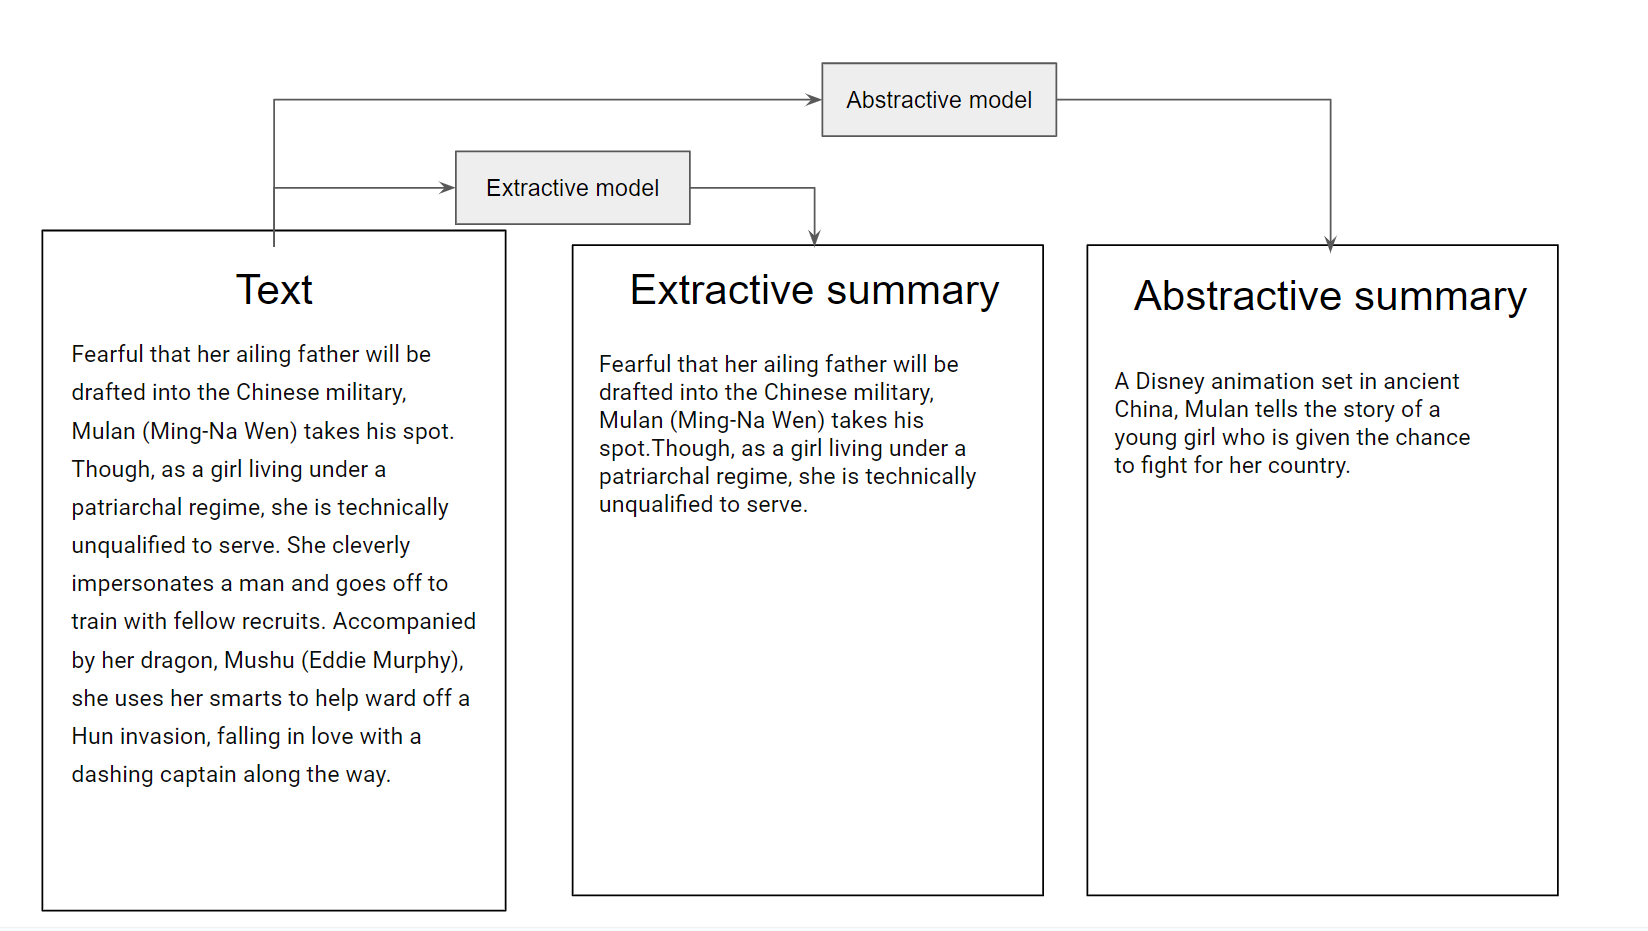

In [1]:
mulan_text = "Fearful that her ailing father will be drafted into the Chinese military, Mulan (Ming-Na Wen) takes his spot. Though, as a girl living under a patriarchal regime, she is technically unqualified to serve. She cleverly impersonates a man and goes off to train with fellow recruits. Accompanied by her dragon, Mushu (Eddie Murphy), she uses her smarts to help ward off a Hun invasion, falling in love with a dashing captain along the way."

In [2]:
%%capture
!pip install sumy
from transformers import PegasusTokenizer, PegasusForConditionalGeneration
import nltk
nltk.download('punkt')
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
import textwrap

In [3]:
%%capture
def summarize_text(input_text, model_name="google/pegasus-xsum"):
    tokenizer = PegasusTokenizer.from_pretrained(model_name)
    model = PegasusForConditionalGeneration.from_pretrained(model_name)
    tokens = tokenizer(input_text, truncation=True, padding="longest", return_tensors="pt")
    summary_ids = model.generate(tokens["input_ids"], early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

summary_abst = summarize_text(mulan_text)


In [4]:
%%capture


parser = PlaintextParser.from_string(mulan_text, Tokenizer("english"))
summarizer = LexRankSummarizer()
summary = summarizer(parser.document, 2)

summary_ext = ""
for sentence in summary:
    summary_ext = summary_ext + str(sentence)


In [5]:
bold = "\033[1m"
reset = "\033[0m"

In [6]:



# Print the wrapped strings
ext_text = "Extractive_summary:\n"
abst_text = "Abstractive_summary:\n"
print(f"{bold}{ext_text}{reset}")
print(textwrap.fill(summary_ext, width=80))

print("\n")
print(f"{bold}{abst_text}{reset}")
print(textwrap.fill(summary_abst, width=80))


Extractive_summary:

Fearful that her ailing father will be drafted into the Chinese military, Mulan
(Ming-Na Wen) takes his spot.Though, as a girl living under a patriarchal
regime, she is technically unqualified to serve.


Abstractive_summary:

A Disney animation set in ancient China, Mulan tells the story of a young girl
who is given the chance to fight for her country.


# Summary Evaluation task


*   Summary evaluation task: given a summary $s$ (extractive or abstractive) and a text $t$/ gold summary $g$ evaluate how infomative $s$ is with respect to $t$/$g$.

*  Benchmark methods include lexical mathcing approaches (ROUGUE), embedding (bertScore) and LM based (Q and A).


* Existing methods don't adhere to an objective unit of information, a gap that LLG aims to fill.


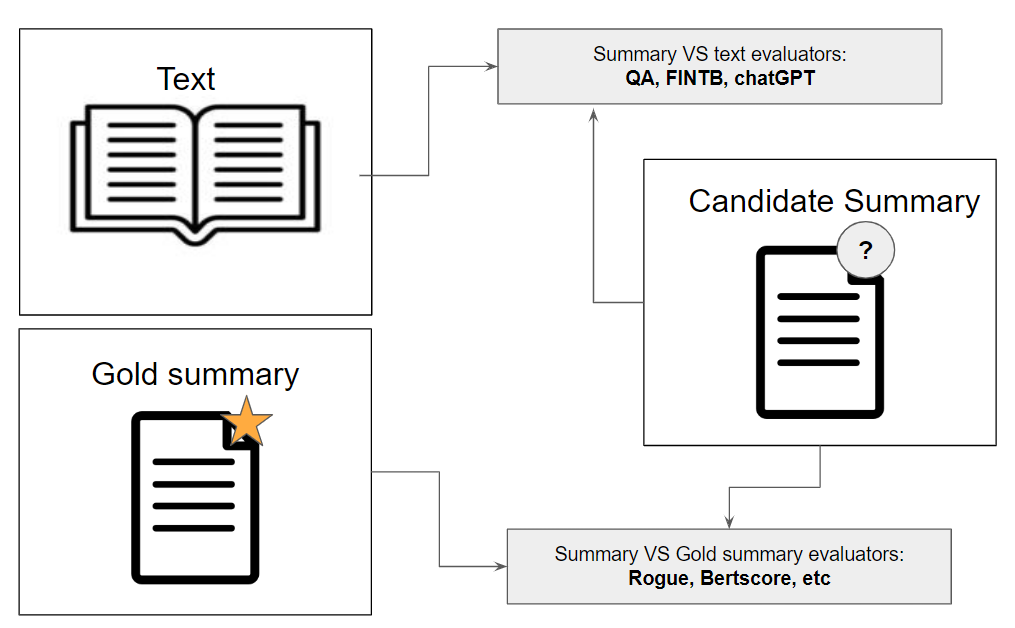

# Shannon game
The LLG metric is based on a the following variation of Shannon Game:

*   Human subjects guess each letter of a text based on precceding letters until they guess the correct letter.
*   For each iteration the number of guesses for current letter is counted.
*   The score of the text is the total number of guesses.
*   This is done with and without a summary as side information and the score of a summary is the reduction in the total number of guesses.





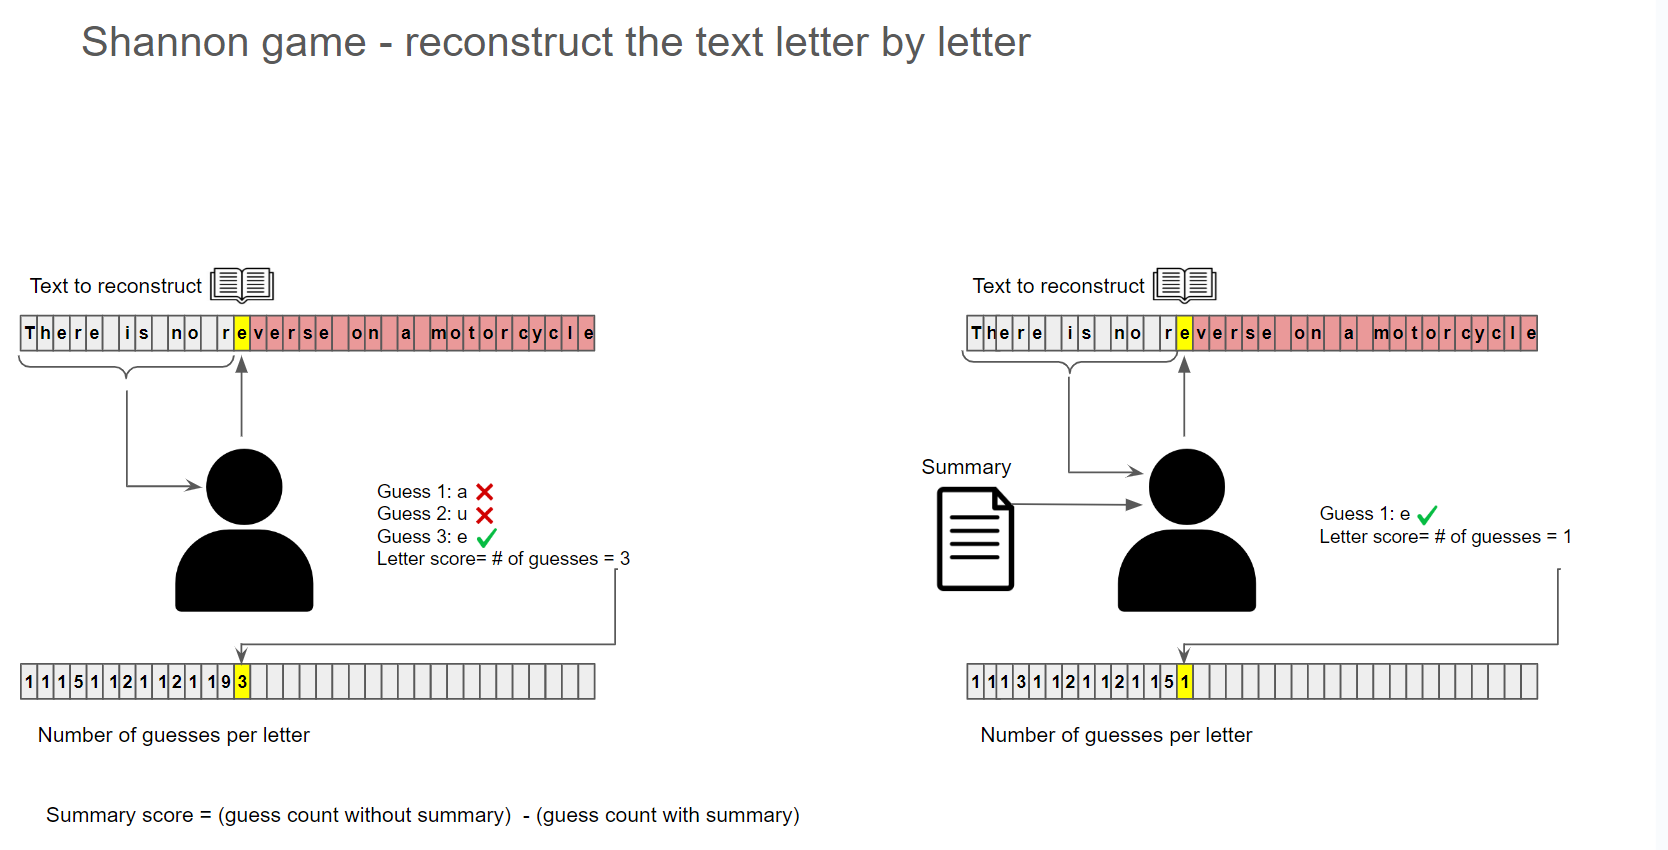

Shannon Game  - https://www.princeton.edu/~wbialek/rome/refs/shannon_51.pdf

Summary variation of Shannon game - https://aclanthology.org/X98-1026.pdf

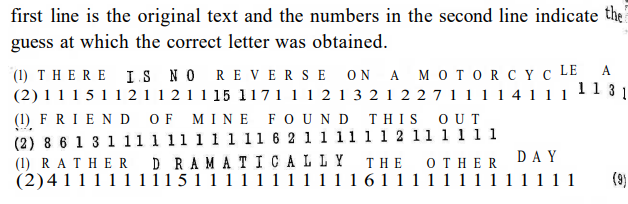

LLG takes the same approach as the Shannon game but replaces the human player with an autoregressive Large Language Model (LLM). At each iteration the LLM outputs a distribution of the current token with the previous tokens given as context and adds the logloss of the true token probability to the total score. This is done with and without a summary as context fed to the LLM. LLG is the reduction between the two.

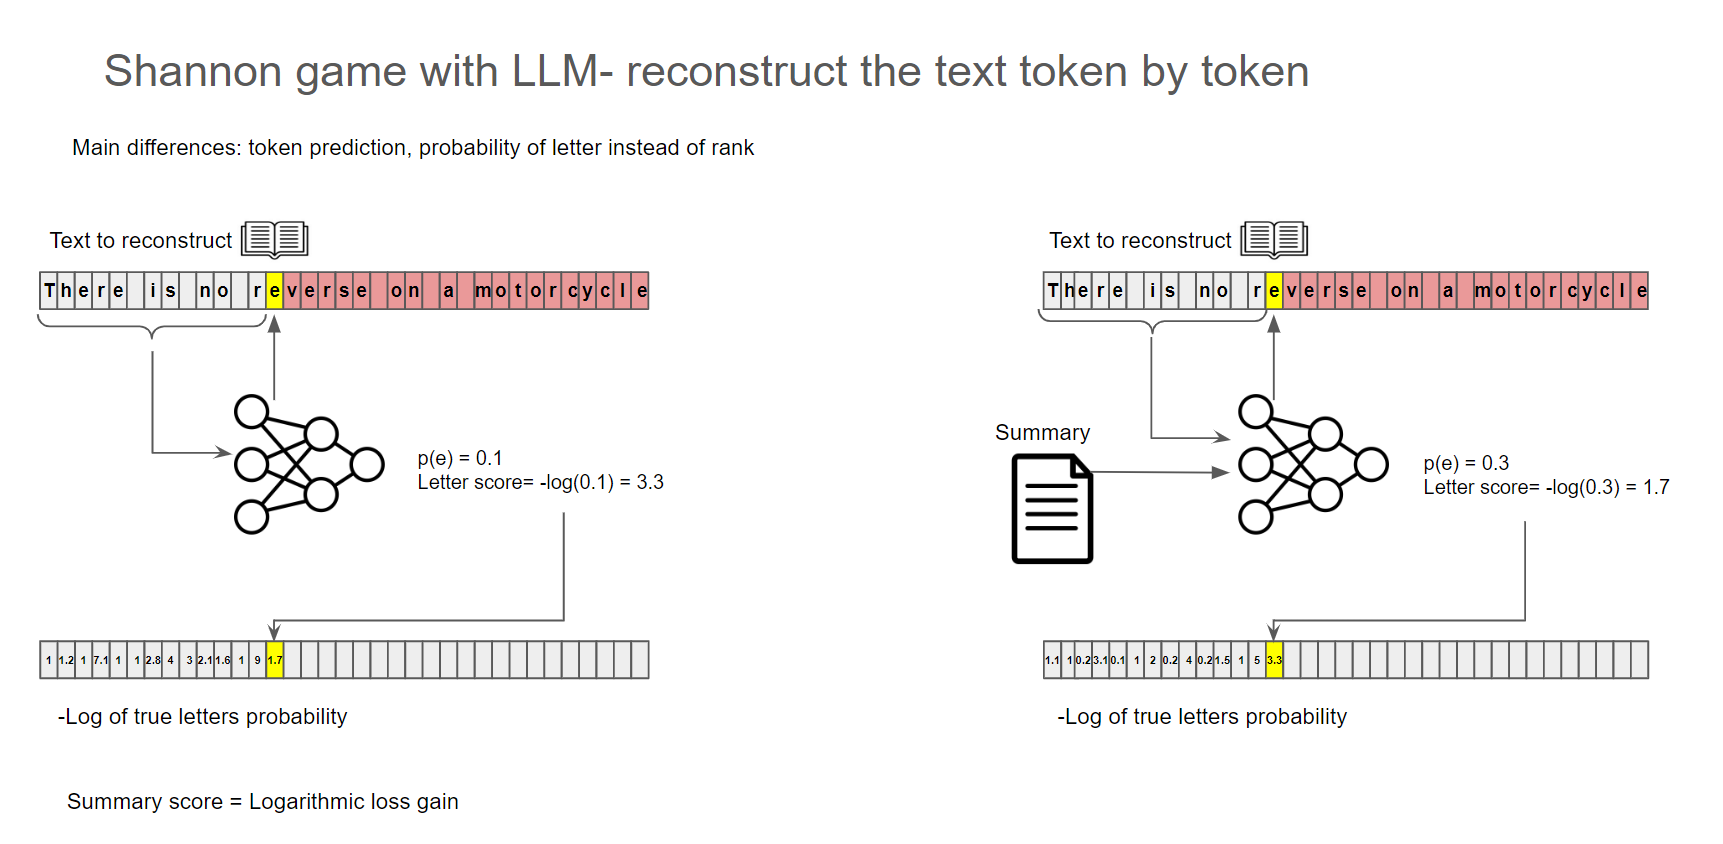

# LLG - Log-Likelihood Gain

$LLG(t, s) = \text{logloss}(t) - \text{logloss}(t|s)$


$\text{logloss}(t) := \text{logloss}(t|\text{PLM}) := -\sum_{i=0}^{n} \log\left( \text{Plm}(t_i|context(t^{i-1}) \right)$


$\text{logloss}(t|s) := \text{logloss}(t|s; \text{PLM}) := -\sum_{i=0}^{n} \log\left( Plm(t_i|context(s,t^{i-1}) \right)$



# LLG code



In [7]:
%%capture
!pip install transformers
!pip install datasets
!pip install ploty
!pip install nltk
!pip install ipywidgets
!pip install spacy
!pip install psutil

In [8]:
import numpy as np
import json
import datasets
from datasets import load_dataset
from itertools import chain
from collections import defaultdict
import pandas as pd
from google.colab import files
import gzip
import io
import pickle
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import kendalltau
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from transformers import GPT2Tokenizer, GPT2LMHeadModel, pipeline
import torch
import nltk
import spacy
from urllib.request import urlretrieve
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import torch.nn.functional as F
from transformers import AutoTokenizer


In [9]:


class LLG_Evaluator:

    def __init__(self):

        self.tokenizer = AutoTokenizer.from_pretrained("gpt2")
        self.model = GPT2LMHeadModel.from_pretrained("gpt2")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.posLanguageModel = spacy.load("en_core_web_sm")
        self.model.to(self.device)
        self.c_pos = ["PROPN", "NOUN", "VERB", "NUM", "ADJ", "ADV"]
        self.f_pos = ["PRON", "DET", "AUX", "PUNCT", "SCONJ", "CCONJ", "SPACE", "PART", "ADP"]
        self.all_pos = ["PROPN", "NOUN", "VERB", "NUM", "ADJ", "ADV", "INTJ", "SYM", "X", "PRON", "DET", "AUX", "PUNCT", "SCONJ", "CCONJ", "SPACE", "PART","ADP"]
        self.counter = 0



    def get_LLG(self, text, summaries):
        '''Returns a list of dicts of all variations of LLG for all summaries corresponding to text '''
        print(self.counter)
        self.counter += 1
        results = []
        losses_none, entry_none = self.get_predictions(text,"")
        for summary in summaries:
            losses, entry = self.get_predictions(text, summary)
            NLLG, NLLG_content, NLLG_function, LLG, LLG_content, LLG_function = self.calc_LLG(entry, entry_none)
            results.append({"NLLG":NLLG, "NLLG_content": NLLG_content, "NLLG_function": NLLG_function, "LLG":LLG, "LLG_content":LLG_content,"LLG_function": LLG_function})
        return results

    def calc_LLG(self, entry, entry_none):
        '''Returns all variations of LLG  for summary, text pair'''
        NLLG = self.calc_LLG_by_pos(entry, entry_none, self.all_pos,True)
        NLLG_content = self.calc_LLG_by_pos(entry, entry_none, self.c_pos,True)
        NLLG_function = self.calc_LLG_by_pos(entry, entry_none, self.f_pos,True)
        LLG = self.calc_LLG_by_pos(entry, entry_none, self.all_pos, False)
        LLG_content = self.calc_LLG_by_pos(entry, entry_none, self.c_pos, False)
        LLG_function = self.calc_LLG_by_pos(entry, entry_none, self.f_pos, False)
        return NLLG, NLLG_content, NLLG_function, LLG, LLG_content, LLG_function


    def calc_LLG_by_pos(self, entry, entry_none, POS, normalize):
        """Calculate a variation of Log-Loss Gain (LLG) based on Part-Of-Speech (POS) tags."""
        score, score_none = 0, 0
        for pos in POS:
            score += entry['Loss'][pos]["sum"]
            score_none += entry_none['Loss'][pos]["sum"]
        if normalize: return (score_none - score) / score_none
        else: return score_none - score




    def get_predictions(self, text, summary):
        """
    Evaluates summary against text by evaluating how well the LM predicts text when
    summary is given as context.

    Args:
    text (string): the full text against which we evaluate the summary.
    summary (string): summary to be evaluated.

    Returns:
    losses (list): List of loss value of all tokens in text with summary as context
    entry (dictionary): loss values of all tokens in text separated into
    each POS (part of speach). Used to analyse impact of content VS function.
    """
        if len(summary) == 0: summary = self.tokenizer.bos_token
        else: summary = self.tokenizer.bos_token + summary
        entry = get_initial_entry()
        losses = []
        sentences = sent_tokenize(text)
        for sentence in sentences:
            sentence_losses, entry = self.get_window_predictions(text=" " + sentence, summary=summary, entry=entry)
            losses.extend(sentence_losses)

        return losses, entry

    def get_window_predictions(self, text, summary, entry):
        """
    Evaluates sentence of text using summary as side information
    Calculate loss of each token and add them to entry according to their pos

    Args:
    text (string): the full text against which we evaluate the summary.
    summary (string): summary to be evaluated.
    entry (dictionary): updated dictionary - loss values of all tokens in text separated into
    each POS (part of speach). Used to analyse impact of content VS function.

    Returns:
    losses (list): List of loss value of all tokens in current sentence with summary as context
    entry (dictionary): loss values of all tokens in current sentence separated into
    each POS (part of speach). Used to analyse impact of content VS function.
    """

        token_indices = self.tokenizer([text], return_offsets_mapping=True)  # tokenize text to get char indices of each token (gpt2 tokenizer)
        token_text = (self.tokenizer.convert_ids_to_tokens(token_indices["input_ids"][0]))  # turn token ids to text
        gpt2_tokens = [(x, (y[0]+1,y[1])) if x[0] == 'Ġ' else (x, (y[0],y[1])) for x, y in zip(token_text, token_indices["offset_mapping"][0])]  # get list of (x= gpt2 text token,y=(start idx, end idx))
        # in gpt2 tokenizer if a word is perceeded by space, 'Ġ' is a part of the token while in spacy it is not, the +1 is a correction for that case for better matching
        text_pos = self.posLanguageModel(text)  # get pos of each token in text
        spacy_tokens = [(token.text, token.idx, token.idx + len(token), token.pos_) for token in text_pos] #get list of (spacy token text, token start idx, token end idx, and pos)

        pos_token_list = []
        for gpt2_token in gpt2_tokens:
            max_token_range, max_pos = max(
                ((min(gpt2_token[1][1], spacy_token[2]) - max(gpt2_token[1][0], spacy_token[1]), spacy_token[3]) for
                 spacy_token in spacy_tokens), key=lambda x: x[0])
            pos_token_list.append((max_pos, gpt2_token))


        losses = []


        input_ids_context = self.tokenizer.encode(summary, return_tensors="pt")
        input_ids_text = self.tokenizer.encode(text, return_tensors="pt")
        input_ids = torch.cat((input_ids_context, input_ids_text), dim=1) # get tokens of summary + text

        start_index = len(input_ids_context[0])  # start index is first index of text
        end_index = len(input_ids[0])  # end index is last index of summary +text

        input_ids = input_ids.clone().detach().to(self.device)
        if input_ids.shape[1] >= 1024:
            print("error - text is too long for model's input - returning empty results")
            return losses,entry

        with torch.no_grad():
            outputs = self.model(input_ids)  # forward on input_ids to get logits of each token
            logits = outputs.logits # get logits

        idx_pos = 0  # running index of pos of token
        for k in range(start_index, end_index):  # get values of every token in text

            true_word_id = input_ids[0,k]  # get curr token index
            word_distribution = F.softmax(logits[:, k-1, :], dim=-1)  # get distribution of curr_token k
            probability_of_word = word_distribution[0, true_word_id]
            loss = -1*torch.log2(probability_of_word)  # get loss of current word
            losses.append(loss.item())

            pos = pos_token_list[idx_pos][0]  # get POS of current token
            # Update entry, add number of tokens added and their values
            entry['Loss'][pos]['sum'] += loss.item()
            entry['Loss'][pos]['length'] += 1


            idx_pos += 1

        return losses, entry

def get_initial_entry():
    entry = {
        "Loss": {},
    }

    categories = [
        "ADJ", "ADP", "ADV", "AUX", "CONJ", "CCONJ", "DET", "INTJ",
        "NOUN", "NUM", "PART", "PRON", "PROPN", "PUNCT", "SCONJ",
        "SYM", "VERB", "X", "SPACE"
    ]

    for category in categories:
        entry["Loss"][category] = {"sum": 0, "length": 0}

    return entry




In [10]:
%%capture
# init llg metric
LLG = LLG_Evaluator()

# LLG example

In the example below we can see how LLG preforms on 4 different summaries. Summary 1 which contains most information, summary 2 which omits one detail, summary 3 which is empty and summary 4 which is irrelvant.

We can see that summary 1 obtains the best score, summary 3 gains no benefit as it is empty and summary 4 even harms the LM predictions as it is irrelevant.

In [11]:
def get_ll_llg(text,summary):
  losses_none, probs_none = LLG.get_predictions(text, "")
  logloss_t = np.sum(losses_none)

  losses,probs = LLG.get_predictions(text, summary)
  logloss_ts = np.sum(losses)
  llg = logloss_t - logloss_ts
  return round(logloss_ts,2),round(llg,2)

In [12]:
text = "The quick brown fox jumped over the lazy dog, then it jumped over a little frog. "
summary1 = "Fox jumps over dog and frog."
summary2 = "Fox jumps over dog."
summary3 = ""
summary4 = "Carbonara ingridients: pasta, 3 eggs, parmesean cheese, pepper, guanciale."

ll,llg = get_ll_llg(text,summary1)
print("logloss(t|s):",ll,"llg", llg, summary1)
ll,llg = get_ll_llg(text,summary2)
print("logloss(t|s):",ll,"llg", llg, summary2)
ll,llg = get_ll_llg(text,summary3)
print("logloss(t|s):",ll,"llg", llg, summary3)
ll,llg = get_ll_llg(text,summary4)
print("logloss(t|s):",ll,"llg", llg, summary4)

logloss(t|s): 87.07 llg 33.76 Fox jumps over dog and frog.
logloss(t|s): 93.62 llg 27.2 Fox jumps over dog.
logloss(t|s): 120.83 llg 0.0 
logloss(t|s): 123.8 llg -2.97 Carbonara ingridients: pasta, 3 eggs, parmesean cheese, pepper, guanciale.


#  NCD Gzip

The results and anlysis will be discussed in NCD section

In [23]:
def gzipGetBits(x):
  x_bytes = (x).encode('utf-8')

  # Compress the string using gzip
  compressed_data = io.BytesIO()
  with gzip.GzipFile(fileobj=compressed_data, mode='wb') as f:
      f.write(x_bytes)


  compressed_length = compressed_data.tell()
  compressed_length_in_bits = compressed_length * 8
  return(compressed_length_in_bits)


In [22]:
def ncdGzip(text,summary):
  z_x = gzipGetBits(summary)
  z_y = gzipGetBits(text)
  z_xy = gzipGetBits(summary+text)
  ncd = (z_xy - z_x)/z_y
  return(ncd)

# summEval Dataset

We run all LLG variations and NCD with gzip on summEval dataset.

SummEval dataset contains 1,700 summaries
of CNN/Daily Mail articles. The dataset is composed of
100 text articles. Each article is paired with 17 summaries
generated from 17 different models, 4 extractive and
13 abstractive. The summaries are scored by 3 human
evaluators over 4 categories: Relevance, Coherence, consistencty, and Fluency. In the anlysis stage we will focus only on Relevance
as it is ideologically closest to information among these
categories.

Uncomment the following cells if you want to run LLG and NCD on full datasets. If not you can download the results for anlysis in the anlysis section.

In [ ]:
# url_summEval_dataset = "https://raw.githubusercontent.com/LevinDana/LLG/main/Datasets/summEval_dataset.jsonl"
# urlretrieve(url_summEval_dataset, 'summEval_dataset.jsonl')
# summEval =  pd.read_json("summEval_dataset.jsonl", lines=True)

In [ ]:
# def replace_semicolon(text):
#   return text.replace(":",".")

# long_text_id = "dm-test-d296270ab4a4cf20f2d9c1aae7514687806f2b35"
# summEval.loc[summEval['id'] == long_text_id, 'text'] = summEval[summEval['id'] == long_text_id]['text'].apply(replace_semicolon)

In [ ]:
# summEval.rename(columns={'expert_annotations': 'full_annotations'}, inplace = True)
# summEval.rename(columns={'decoded': 'summary'}, inplace = True)
# summEval.drop(columns=["id", "turker_annotations","filepath","metric_scores_1","metric_scores_6","metric_scores_11","references"], inplace=True)
# summEval = summEval[["text","summary","full_annotations","model_id"]]

In [ ]:
# def get_mean_annotations(annotations):
#   mean_annotations = {key: sum(d[key] for d in annotations) / len(annotations) for key in annotations[0]}
#   return [mean_annotations]

# summEval["annotations"] = summEval["full_annotations"].apply(get_mean_annotations)

In [ ]:
# summEval.head(3)

In [ ]:
# Uncomment if you want to Run all variations of LLG on summEval dataset

In [ ]:
# # Run all variations of LLG on summEval dataset

# def merge_columns(text, summary, annotations, model_id, llg, full_annotations):
#     return [{'text': text,'summary' : summary[i], 'annotations': annotations[i], 'model_id': model_id[i],'llg': [llg[i]], 'full_annotations': full_annotations[i]} for i in range(len(summary))]


# grouped_df = summEval.groupby('text').agg({'summary': list, 'annotations': list, "model_id": list, "full_annotations": list}).reset_index()
# grouped_df['llg'] = grouped_df.apply(lambda row: LLG.get_LLG(row['text'], row['summary']), axis=1)
# grouped_df['merged_column'] = grouped_df.apply(lambda row: merge_columns(row['text'],row['summary'], row['annotations'], row['model_id'], row['llg'], row['full_annotations']), axis=1)
# df = grouped_df.drop(['summary', 'text', 'llg', "model_id","annotations","full_annotations"], axis=1)
# df = df.explode('merged_column')



# summEval = pd.json_normalize(df['merged_column'])



In [ ]:
# # Run ncd with gzip on summEval dataset
# summEval["ncdGzip"] = summEval.apply(lambda x: ncdGzip(x["text"],x["summary"]), axis=1)

In [ ]:
# # save file to pickle and download

# summEval.to_pickle('summEval_llg_ncd.pkl')

# files.download('summEval_llg_ncd.pkl')

#Learning from human feedback (SSF) : CNN and DailyMail

This dataset contains 6312 summaries of CNN/Daily Mail articles. Each
article is scored by a human evaluator over 3 categories:
Coverage, Coherence, and Accuracy. We focus on Coverage as it ideologically appears to be the closest to information among these categories.

Uncomment the following cells if you want to run LLG and NCD on full datasets. If not you can download the results for anlysis in the anlysis section.

In [ ]:
# %%capture
# ssf = load_dataset("openai/summarize_from_feedback", 'axis')

In [ ]:
# ssf = ssf['test'].to_pandas()

In [ ]:
# remove_compatible = lambda axes: {key: value for key, value in axes.items() if key != 'compatible' and key != "overall"}
# ssf['annotations'] = ssf['summary'].apply(lambda x: remove_compatible(x['axes']))
# ssf['text'] = ssf['info'].apply(lambda x: x.get('article'))
# ssf.rename(columns={'summary': 'summary_details'}, inplace = True)
# ssf['summary'] = ssf['summary_details'].apply(lambda x: x.get('text'))
# ssf.drop(columns=["split","batch","summary_details","worker"], inplace=True)
# ssf = ssf[["text","summary","annotations","info"]]

In [ ]:
# ssf.head(4)

In [ ]:
# # Run all variations of LLG on ssf dataset

# def merge_columns(text, summary, annotations, info, llg):
#     return [{'text': text,'summary' : summary[i], 'annotations': [annotations[i]], 'info': [info[i]],'llg': [llg[i]]} for i in range(len(summary))]


# grouped_df = ssf.groupby('text').agg({'summary': list, 'annotations': list, "info": list}).reset_index()
# grouped_df['llg'] = grouped_df.apply(lambda row: LLG.get_LLG(row['text'], row['summary']), axis=1)
# grouped_df['merged_column'] = grouped_df.apply(lambda row: merge_columns(row['text'],row['summary'], row['annotations'], row['info'], row['llg']), axis=1)
# df = grouped_df.drop(['summary', 'text', 'llg', "info","annotations"], axis=1)
# df = df.explode('merged_column')



# ssf = pd.json_normalize(df['merged_column'])


In [ ]:
# ssf.head()

In [ ]:
# # Run ncd with gzip on summEval dataset
# ssf["ncdGzip"] = ssf.apply(lambda x: ncdGzip(x["text"],x["summary"]), axis=1)

In [ ]:
# # save file to pickle and download

# ssf.to_pickle('ssf_llg_ncd.pkl')

# files.download('ssf_llg_ncd.pkl')

# Anlysis

We evaluate pairwise (sample) correlation between human annotations and LLG. We evaluate both Kendall Tau and Pearson correlation. We correlate over "relevance" dimension for summEval and "coverage" dimension for SSF, as they are the dimension closest to "information".

In [13]:
#This cell downloads the results obtained by running LLG and NCD on summEval and SFF datasets. To reproduce the results yourself, uncomment and run previous cells.
url_summEval = "https://github.com/LevinDana/LLG/raw/main/llg_ncd_results/summEval_llg_ncd.pkl"
urlretrieve(url_summEval, 'summEval_llg_ncd.pkl')
url_ssf = "https://github.com/LevinDana/LLG/raw/main/llg_ncd_results/ssf_llg_ncd.pkl"
urlretrieve(url_ssf, 'ssf_llg_ncd.pkl')
summEval_llg_ncd = pd.read_pickle('summEval_llg_ncd.pkl')
ssf_llg_ncd = pd.read_pickle('ssf_llg_ncd.pkl')

In [14]:
def cor_with_annotators_llg(df, metric, dim):
  df[dim] = df["annotations"].apply(lambda x: x[0][dim])
  df[metric] = df["llg"].apply(lambda x: x[0][metric])
  annotation_list = df[dim].tolist()
  llg_list = df[metric].tolist()
  df.drop(columns=[dim, metric],inplace = True)
  return round(kendalltau(annotation_list, llg_list)[0],2), round(pearsonr(annotation_list, llg_list)[0],2)


In [15]:
k_summEval,p_summEval = cor_with_annotators_llg(summEval_llg_ncd, "LLG", "relevance")
k_ssf,p_ssf = cor_with_annotators_llg(ssf_llg_ncd, "LLG", "coverage")

data = {
    'Correlation method': ['KENDALL τ', 'PEARSON'],
    'SummEval': [str(k_summEval), str(p_summEval)],
    'SFF': [str(k_ssf), str(p_ssf)]
}

print(tabulate(pd.DataFrame(data), headers='keys', tablefmt='pretty', showindex=False))


+--------------------+----------+------+
| Correlation method | SummEval | SFF  |
+--------------------+----------+------+
|     KENDALL τ      |   0.24   | 0.2  |
|      PEARSON       |   0.34   | 0.27 |
+--------------------+----------+------+


# Information Theoretical Justifications

# Loseless Compression with side information (Arithmetic coding)

We show that LLG can be viewed as the reduction in the binary
codelength when compressing a text t using a lossless compression procedure when the summary text s is provided as
side information. This compression procedure involves a pre-trained LM followed by an arithmetic encoder as illustrated in the figure below.


The encoding process is as follows. Let $t = t^{n} = (t_1,\ldots,t_n)$ be the text and $s$ the summary text. Assume that the LM provides a probability distribution over a finite dictionary of tokens given the context $ctx(s)$.
Next we partition $[a_{1},b_{1})$ by the distribution $P_{lm}(\cdot|ctx({s},t_1))$ and find the interval $[a_{2},b_{2})$ corresponding to $t_2$. We continue until we reach $t_n$, partition and find its corresponding interval by $P_{lm}(\cdot|ctx(s,t^{n-1}))$ and $P_{lm}(t_n|ctx(s,t^{n-1}))$.

To get the encoded representation of $t$, we use, for simplicity, the Shannon-Fano-Elias method of taking the first $\left\lceil logloss(t|ctx(s)) \right\rceil + 1$ bits in the binary representation of the midpoint of the final interval $[a_{n},b_{n}) \subset [0,1]$, excluding the leading $0$. This representation attains within two bits of the shortest prefix-free binary code which falls within the final interval $[a_{n},b_{n})$. We denote the final binary representation by $C(t|s)$. Note that $C(t|s)$ depends on the LM and the way it processes $s$ and previous tokens to form a context. We denote by $C(t)$ the binary representation obtained under a similar procedure but without $s$ in the context as illustrated in the left-hand side of the figure below.

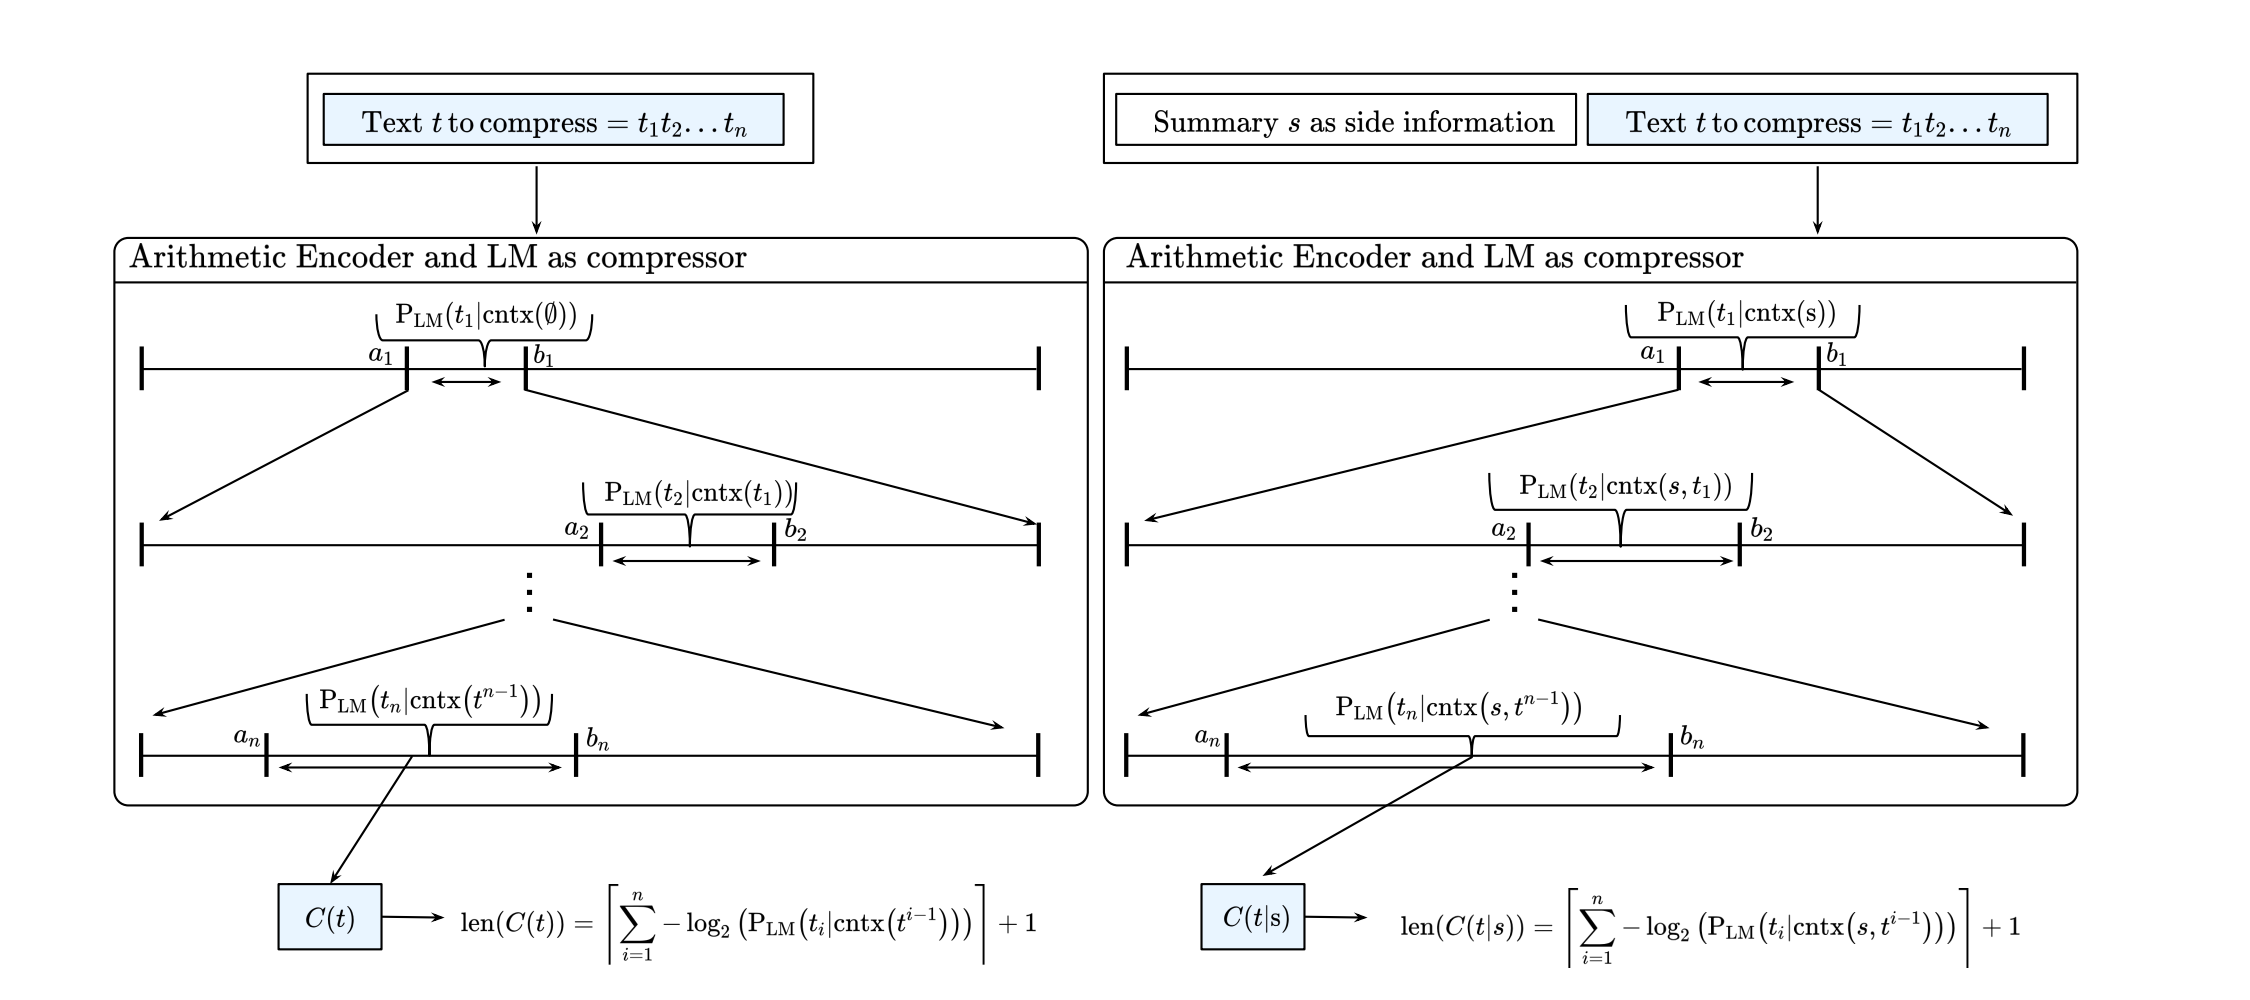


###$LLG(t, s) = \text{logloss}(t) - \text{logloss}(t|s) ≈ len(C(t)) - len(C(t|s))$

# Normalized Compression Distance (NCD)


The Normalized Compression Distance [(NCD)](https://arxiv.org/pdf/cs/0111054) is a universal
similarity measure between two data objects x and y, regardless of their domain (texts, images, genes, etc), by analyzing the objects' compressed
forms using a compressor Z. Denoting by Z(xy) the
length (in bits) of jointly compressing x and y under z, the
NCD is defined as

$ NCD_{Z}(x,y) = \frac{Z(xy) - \min\{Z(x),Z(y)\}}{\max\{Z(x),Z(y)\}}$

NCD's score is in the range 0-1. Low NCD indicate high similarity between x and y.

We justify the use of LLG by showing that under normalization it adheres to NCD:


$LLG(t, s) = \text{logloss}(t) - \text{logloss}(t|s)$

$NLLG(t,s) := \frac{logloss(t) - logloss(t|s)}{logloss(t)}= \frac{lenC(t) - lenC(t|s)}{lenC(t)}$


$\begin{align*}
NCD_{C}(s,t) & = \frac{len{C(s,t)} - \min\{len{C(s)},len{C(t)}\}}{\max\{len{C(s)},len{C(t)}\}} \\
& = \frac{len{C(s,t)} - len{C(s)}}{len{C(t)}} \\
& = \frac{len{C(s)} + len{C(t|s)} - len{C(s)}}{len{C(t)}} \\
& = \frac{len{C(t|s)}}{len{C(t)}} = 1 - NLLG(t|s).
\end{align*}$

In the following empirical results we show that while LLG and NCD(gzip) correlate with one another, LLG, which benefits from deeper language understanding of the LM, obtains better results than NCD in correlation with human annotators.

In [16]:
def cor_with_annotators_gzip(df, dim):
  df[dim] = df["annotations"].apply(lambda x: x[0][dim])
  gzip_list = df["ncdGzip"].tolist()
  annotation_list = df[dim].tolist()
  df.drop(columns=[dim],inplace = True)
  return round(kendalltau(annotation_list, gzip_list)[0],2), round(pearsonr(annotation_list, gzip_list)[0],2)

In [17]:
def cor_llg_gzip(df,metric):
  df[metric] = df["llg"].apply(lambda x: x[0][metric])
  gzip_list = df["ncdGzip"].tolist()
  llg_list = df[metric].tolist()
  df.drop(columns=[metric],inplace = True)
  return round(kendalltau(llg_list, gzip_list)[0],2), round(pearsonr(llg_list, gzip_list)[0],2)

In the following table we show that NLLG and NCD with gzip have high correlation.

In [18]:
k_gzipnllg_se,p_gzipnllg_se = cor_llg_gzip(summEval_llg_ncd, "NLLG")
k_gzipnllg_ssf,p_gzipnllg_ssf = cor_llg_gzip(ssf_llg_ncd, "NLLG")


data = {
    'Correlation method': ['KENDALL τ', 'PEARSON'],
    'SummEval': [str(k_gzipnllg_se), str(p_gzipnllg_se)],
    'SFF': [str(k_gzipnllg_ssf), str(p_gzipnllg_ssf)]
}

print(tabulate(pd.DataFrame(data), headers='keys', tablefmt='pretty', showindex=False))

+--------------------+----------+-------+
| Correlation method | SummEval |  SFF  |
+--------------------+----------+-------+
|     KENDALL τ      |  -0.55   | -0.56 |
|      PEARSON       |  -0.77   | -0.82 |
+--------------------+----------+-------+


In the following table we show that NLLG outperforms NCD with gzip in correlation with human annotators.

In [19]:
k_gzip_se,p_gzip_se = cor_with_annotators_gzip(summEval_llg_ncd, "relevance")
k_gzip_ssf,p_gzip_ssf = cor_with_annotators_gzip(ssf_llg_ncd, "coverage")
k_nllg_se,p_nllg_se = cor_with_annotators_llg(summEval_llg_ncd, "NLLG", "relevance")
k_nllg_ssf,p_nllg_ssf = cor_with_annotators_llg(ssf_llg_ncd, "NLLG", "coverage")


data = {
    'Metric': ['NLLG', '', 'NCD_gzip', ''],
    'Correlation method': ['KENDALL τ', 'PEARSON', 'KENDALL τ', 'PEARSON'],
    'SummEval': [str(k_nllg_se), str(p_nllg_se), str(k_gzip_se), str(p_gzip_se)],
    'SFF': [str(k_nllg_ssf), str(p_nllg_ssf), str(k_gzip_ssf), str(p_gzip_ssf)]
}



print(tabulate(pd.DataFrame(data), headers='keys', tablefmt='pretty', showindex=False))


+----------+--------------------+----------+-------+
|  Metric  | Correlation method | SummEval |  SFF  |
+----------+--------------------+----------+-------+
|   NLLG   |     KENDALL τ      |   0.25   | 0.29  |
|          |      PEARSON       |   0.37   | 0.41  |
| NCD_gzip |     KENDALL τ      |  -0.18   | -0.26 |
|          |      PEARSON       |  -0.27   | -0.34 |
+----------+--------------------+----------+-------+


# Content and Structure seperation

In some linguistics and information retrieval studies it is
useful to separate the text into function words, associated with
the text’s structure or style, while the rest of the words are
associated with the text’s content;


<font color='blue'>In this</font> <font color='red'>sentence content words</font> <font color='blue'>are in</font> <font color='red'>red</font> <font color='blue'>and</font> <font color='red'>structure words</font> <font color='blue'>are in</font> <font color='red'>blue.</font>


Although summarization is conceptually associated
with the text’s content, LLG considers all tokens
of the text regardless of their association to structure or
content. In what follows, we analyze the contribution of each
token type to the LLG and empirically show that structure
tokens affect very little on LLG. Namely, LLG tends to
ignore information conveyed by the text’s structure which is
a desirable property of a summarization evaluation metric.

The following figure depicts the histograms of $LLG$, $LLG^{cont}$, and
$LLG^{stru}$ over all text-summary pairs per dataset. It follows
from this figure that LLG values are similar to $LLG^{cont}$ and
are significantly less affected by $LLG^{stru}$.

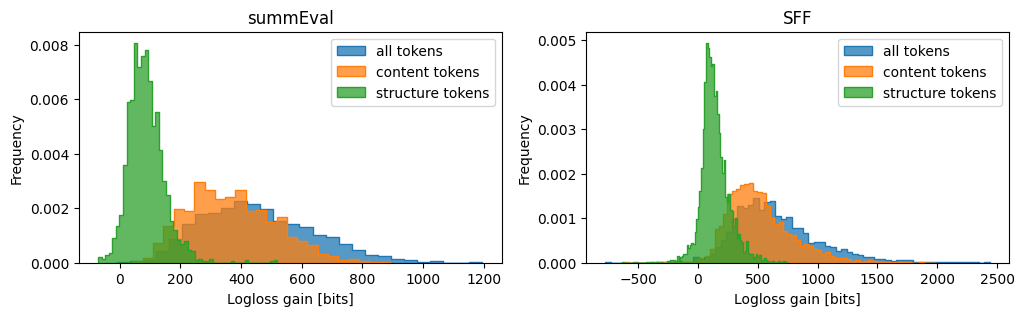

In [20]:
llg_se = summEval_llg_ncd["llg"].apply(lambda x: x[0]["LLG"]).tolist()
llgc_se = summEval_llg_ncd["llg"].apply(lambda x: x[0]["LLG_content"]).tolist()
llgf_se = summEval_llg_ncd["llg"].apply(lambda x: x[0]["LLG_function"]).tolist()


llg_ssf = ssf_llg_ncd["llg"].apply(lambda x: x[0]["LLG"]).tolist()
llgc_ssf = ssf_llg_ncd["llg"].apply(lambda x: x[0]["LLG_content"]).tolist()
llgf_ssf = ssf_llg_ncd["llg"].apply(lambda x: x[0]["LLG_function"]).tolist()

fig, axs = plt.subplots(1, 2, figsize=(12, 3))


sns.histplot(llg_se, label='all tokens', ax=axs[0], stat="density",element="step")
sns.histplot(llgc_se, label='content tokens', ax=axs[0], stat="density",element="step")
sns.histplot(llgf_se, label='structure tokens', ax=axs[0], stat="density",element="step")

axs[0].set_xlabel('Logloss gain [bits]')
axs[0].set_ylabel('Frequency')
axs[0].legend()
axs[0].set_title("summEval")


sns.histplot(llg_ssf, label='all tokens', ax=axs[1], stat="density",element="step")
sns.histplot(llgc_ssf, label='content tokens', ax=axs[1], stat="density",element="step")
sns.histplot(llgf_ssf, label='structure tokens', ax=axs[1], stat="density",element="step")

axs[1].set_xlabel('Logloss gain [bits]')
axs[1].set_ylabel('Frequency')
axs[1].legend()
axs[1].set_title("SFF")

plt.savefig('histogramsIDiff.pdf', format='pdf', bbox_inches='tight')
plt.show()


We further compare
all $LLG$ variants as summarization metrics by checking their
correlation with human evaluation scores. The following results show
that $LLG$ correlates with human evaluation very similarly to
$LLG^{cont}$ and both outperform $LLG^{stru}$. This behavior suggests
that $LLG$ naturally removes the impact of structure tokens
since, in contrast to content tokens, they are about equally
predictable whether or not side information is present. This is
clearly a desired behavior for summary evaluation.

In [21]:
k_llg_se,p_llg_se = cor_with_annotators_llg(summEval_llg_ncd, "LLG", "relevance")
k_llg_ssf,p_llg_ssf = cor_with_annotators_llg(ssf_llg_ncd, "LLG", "coverage")

k_llgc_se,p_llgc_se = cor_with_annotators_llg(summEval_llg_ncd, "LLG_content", "relevance")
k_llgc_ssf,p_llgc_ssf = cor_with_annotators_llg(ssf_llg_ncd, "LLG_content", "coverage")

k_llgf_se,p_llgf_se = cor_with_annotators_llg(summEval_llg_ncd, "LLG_function", "relevance")
k_llgf_ssf,p_llgf_ssf = cor_with_annotators_llg(ssf_llg_ncd, "LLG_function", "coverage")



data = {
    'Metric': ['LLG', '', 'LLG_content', '', "LLG_function", ''],
    'Correlation method': ['KENDALL τ', 'PEARSON', 'KENDALL τ', 'PEARSON', 'KENDALL τ', 'PEARSON'],
    'SummEval': [str(k_llg_se), str(p_llg_se), str(k_llgc_se), str(p_llgc_se), str(k_llgf_se), str(p_llgf_se)],
    'SFF': [str(k_llg_ssf), str(p_llg_ssf), str(k_llgc_ssf), str(p_llgc_ssf), str(k_llgf_ssf), str(p_llgf_ssf)]
}




print(tabulate(pd.DataFrame(data), headers='keys', tablefmt='pretty', showindex=False))

+--------------+--------------------+----------+------+
|    Metric    | Correlation method | SummEval | SFF  |
+--------------+--------------------+----------+------+
|     LLG      |     KENDALL τ      |   0.24   | 0.2  |
|              |      PEARSON       |   0.34   | 0.27 |
| LLG_content  |     KENDALL τ      |   0.22   | 0.21 |
|              |      PEARSON       |   0.32   | 0.29 |
| LLG_function |     KENDALL τ      |   0.18   | 0.12 |
|              |      PEARSON       |   0.28   | 0.17 |
+--------------+--------------------+----------+------+
